### 1. 목적

조개 나이 예측 -> 혹시 기후 변화 관련 ? 

### 2. 데이터셋

이 데이터셋은 조개의 여러 특성에 관한 정보를 제공합니다. 각 열의 의미는 다음과 같습니다:

1. **Sex**: 조개의 성별을 나타냅니다. 'M'은 수컷, 'F'는 암컷, 'I'는 유아기를 나타냅니다.
2. **Length**: 조개의 가장 긴 부분의 길이를 나타냅니다.
3. **Diameter**: 수직으로 측정한 조개의 직경을 나타냅니다.
4. **Height**: 조개의 높이를 나타냅니다(조개껍질 포함).
5. **Whole weight**: 조개 전체의 무게를 나타냅니다.
6. **Shucked weight**: 조개의 살만을 제거한 무게를 나타냅니다.
7. **Viscera weight**: 조개의 내장 무게를 나타냅니다.
8. **Shell weight**: 조개껍질의 무게를 나타냅니다.
9. **Rings**: 조개의 나이를 나타냅니다. 일반적으로, 링의 개수에 1.5를 더하면 조개의 나이(년)가 됩니다.

각 행은 특정 조개의 위 특성을 나타냅니다. 이 데이터를 사용하여 조개의 특성과 나이 사이의 관계를 분석할 수 있습니다. 예를 들어, 회귀 분석을 사용하여 특정 특성(예: 무게, 길이 등)이 조개의 나이에 어떤 영향을 미치는지 예측할 수 있습니다.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [2]:
data_reg = pd.read_csv('./csv/Regression_data.csv')

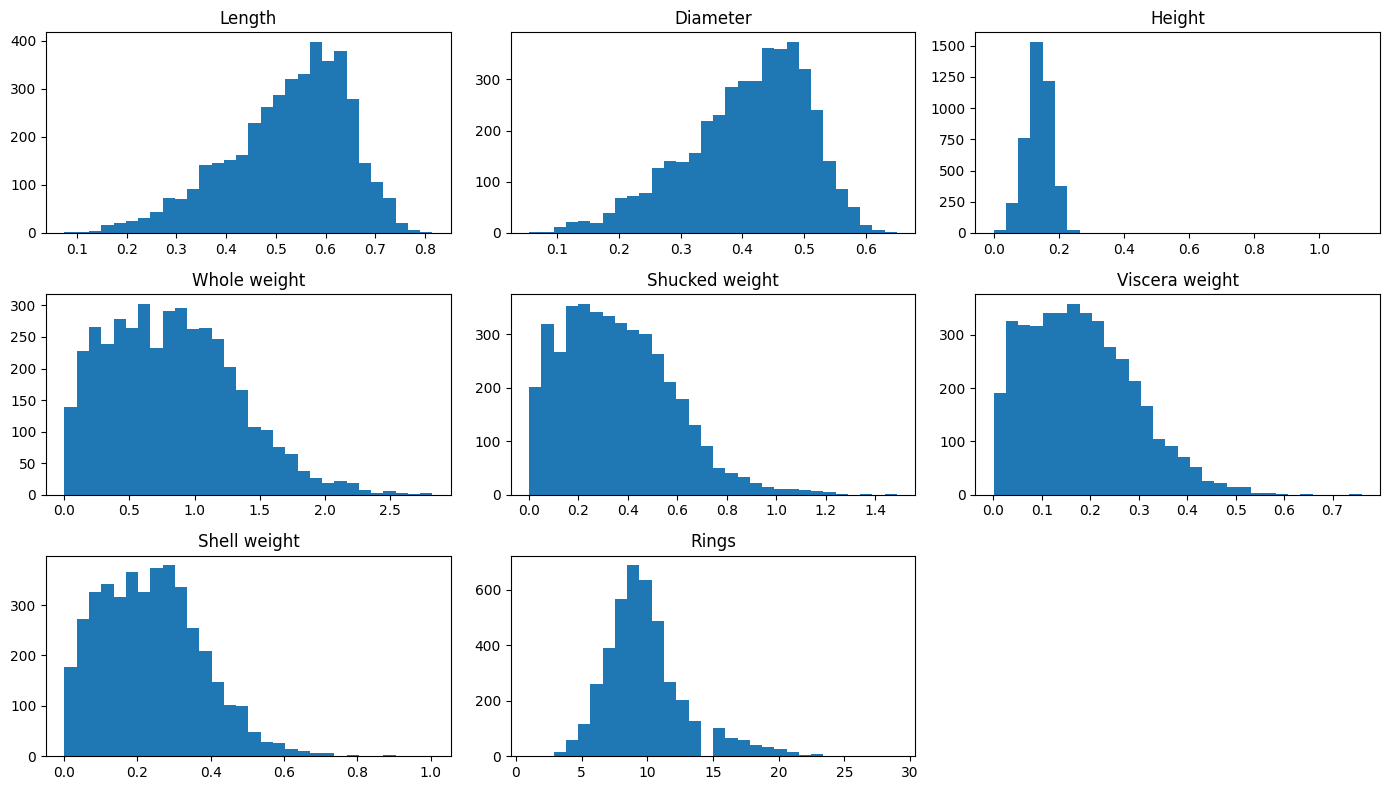

In [3]:
def hist(column):
    plt.hist(column, bins=50)
    plt.title(f'{column.name} hist')
    plt.show()

data_reg.select_dtypes(include=[float, int]).hist(bins=30, figsize=(14,8), grid=False)
plt.tight_layout()
plt.show()
# 수치형데이터 분포 확인
# right skewed : column 4, 5, 6, 7
# left skewed : column 1, 2
# outlier 존재 : column 3
# 타겟 데이터는 약한 right skewed

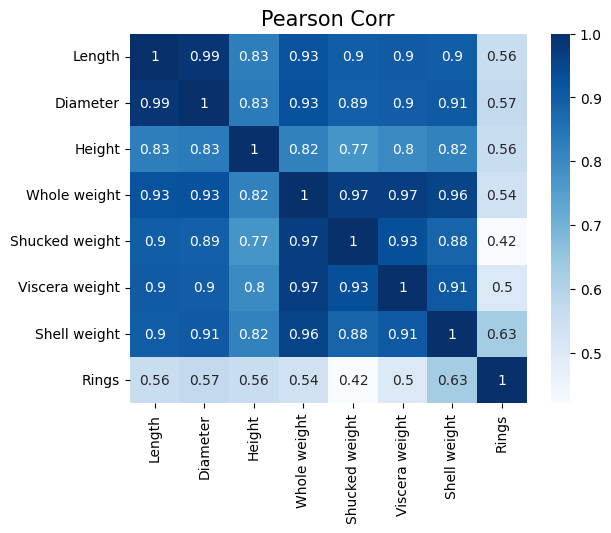

In [4]:
# column3 (Height) 아웃라이어 : 1.130, 0.515
data_reg.Height.sort_values(ascending=False)[:5]

# 상관계수 확인
sns.heatmap(data_reg.iloc[:,1:].corr().abs(), annot=True, cmap='Blues')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# 전반적으로 컬럼들의 상관계수가 높다.
# (Length, Diameter) (Whole wieght, Shucked weight)가 상관계수 높음

### EDA 및 set split

In [5]:
print(data_reg.describe())

print(data_reg[data_reg['Height']==0])

# Height 컬럼에 최소값이 0인 것 2개 확인 -> 삭제 필요

            Length     Diameter       Height  Whole weight  Shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.

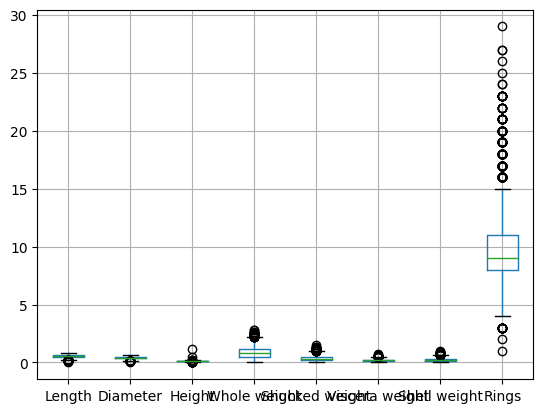

<Figure size 2000x1500 with 0 Axes>

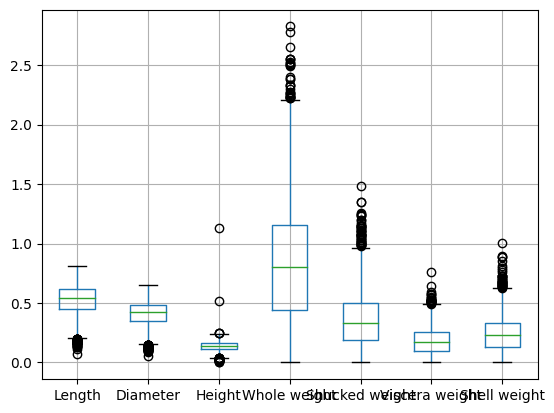

<Figure size 2000x1500 with 0 Axes>

In [6]:
data_reg.boxplot()
plt.figure(figsize=(20,15))
plt.show()


# 종속변수 제외
boxplot_data = data_reg.drop('Rings', axis=1)

boxplot_data.boxplot()
plt.figure(figsize=(20,15))
plt.show()

In [7]:
#Height에 이상치 : 0인 것, 1.13인 것
data_reg[data_reg['Height']==0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [8]:
#Height에 이상치 : 0인 것, 1.13인 것
data_reg[data_reg['Height']==1.13]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
2051,F,0.455,0.355,1.13,0.594,0.332,0.116,0.1335,8


In [9]:
# Remove rows where 'Height' is 0 or 1.13
data_reg = data_reg[(data_reg['Height'] != 0) & (data_reg['Height'] != 1.13)]

Shucked weight의 min, max 값의 차이가 커서 로그 변환을 사용하여 데이터를 더 정규 분포에 가깝게 만들어 봄. 

다시 정리해보면, 

Scaling: 값의 범위를 줄이기 위해 스케일링을 수행 가능함. StandardScaler는 데이터를 평균이 0이고 표준 편차가 1인 분포로 변환. MinMaxScaler는 모든 특성을 0과 1 사이로 조정.  

Log Transformation: 데이터가 한쪽으로 치우쳐져 있거나 특성의 값이 지수적으로 증가할 때 로그 변환을 사용하여 데이터를 더 정규 분포에 가깝게 만들 수 있음. 이는 특히 회귀 문제에서 유용.

Outlier Removal: 값이 너무 높거나 너무 낮은 이상치를 제거할 수 있음. 이상치는 종종 기계 학습 모델의 성능을 저하시키기 때문.

In [10]:

# Remove rows where 'Shucked weight' is less than or equal to 0.01
# data_reg = data_reg[data_reg['Shucked weight'] > 0.01]  # shucked weight에서 너무 작은 값들을 조정해가며 삭제해봤으니 RMSE 점수가 삭제 안하는 것이 가장 좋음.

In [11]:
# Reset the index of the dataframe
data_reg = data_reg.reset_index(drop=True)

In [12]:
# Separate the features and the target
X_reg = data_reg.drop("Rings", axis=1)
y_reg = data_reg["Rings"]

# Apply one-hot encoding to the 'Sex' feature
encoder = OneHotEncoder(sparse=False, drop='first')
sex_encoded = encoder.fit_transform(X_reg[['Sex']])
sex_encoded_df = pd.DataFrame(sex_encoded, columns=['Sex_Female', 'Sex_Infant'], index=X_reg.index) # add index=X_reg.index


# sex_encoded_df = pd.DataFrame(sex_encoded, columns=encoder.get_feature_names(['Sex']))

# Replace the 'Sex' column with the encoded columns
X_reg = X_reg.drop("Sex", axis=1)
X_reg = pd.concat([X_reg, sex_encoded_df], axis=1)

# Split the data into training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

X_train_reg.head()

c:\ProgramData\anaconda3\envs\TeamProject\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_Female,Sex_Infant
554,0.485,0.390,0.125,0.5910,0.2870,0.141,0.1200,1.0,0.0
2661,0.570,0.450,0.135,1.0200,0.5460,0.204,0.2500,0.0,1.0
2413,0.400,0.315,0.105,0.2870,0.1135,0.037,0.1130,0.0,1.0
1954,0.645,0.510,0.180,1.6195,0.7815,0.322,0.4675,0.0,0.0
1945,0.635,0.525,0.160,1.1950,0.5435,0.246,0.3350,0.0,1.0


<Axes: >

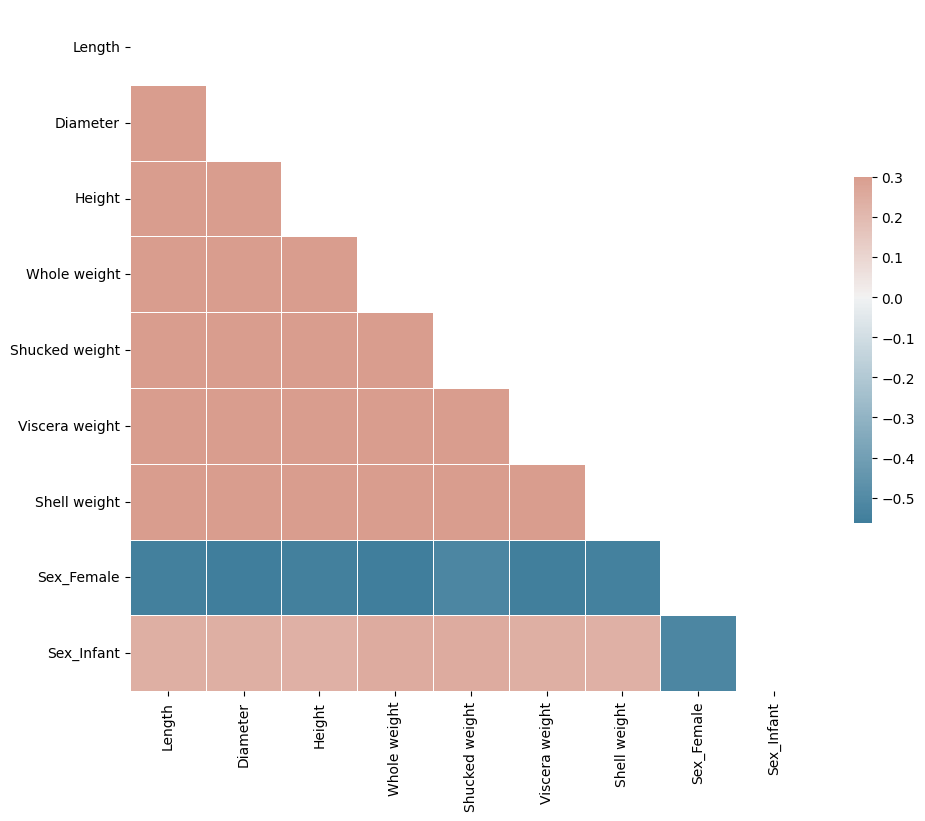

In [13]:

# Compute the correlation matrix
corr = X_reg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: >

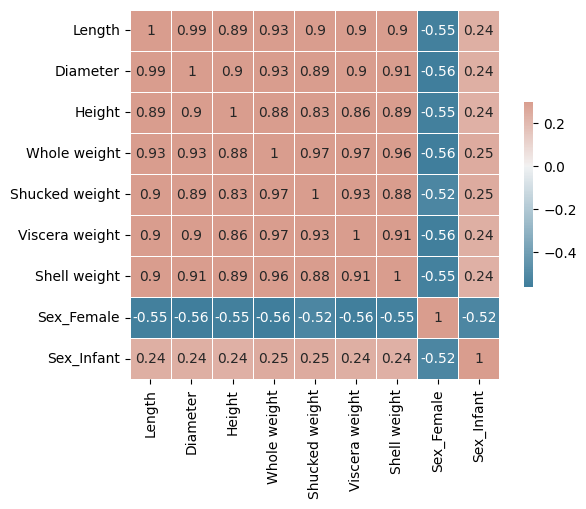

In [14]:
# Draw the heatmap with the mask and correct aspect ratio
# Here, we will not use the mask, and add the annotation to display the correlation scores
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### 회귀모델학습

In [15]:
# Initialize a linear regression model
model_reg = LinearRegression()

# Fit the model to the training data
model_reg.fit(X_train_reg, y_train_reg)

# Use the model to make predictions on the test data
y_pred_reg = model_reg.predict(X_test_reg)

# Calculate the performance metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("평균 제곱 오차 (Mean Squared Error, MSE):", mse)
print("평균 제곱근 오차 (Root Mean Squared Error, RMSE):", rmse)
print("평균 절대 오차 (Mean Absolute Error, MAE):", mae)
print("결정 계수 (R^2 Score):", r2)

평균 제곱 오차 (Mean Squared Error, MSE): 4.626032551091537
평균 제곱근 오차 (Root Mean Squared Error, RMSE): 2.1508213666159115
평균 절대 오차 (Mean Absolute Error, MAE): 1.5419952981175713
결정 계수 (R^2 Score): 0.5963499952525424


- 평균 제곱 오차 (MSE)와 평균 제곱근 오차 (RMSE)는 실제 값과 예측 값의 차이를 제곱하여 평균한 값입니다. 이 값이 작을수록 모델의 성능이 좋다고 할 수 있습니다.

- 평균 절대 오차 (MAE)는 실제 값과 예측 값의 차이를 절대값으로 변환하여 평균한 값입니다. 이 값도 작을수록 모델의 성능이 좋다고 할 수 있습니다.

- 결정 계수 (R^2 Score)는 회귀 모델이 데이터를 얼마나 잘 설명하는지를 나타내는 지표입니다. 이 값이 1에 가까울수록 모델이 데이터를 잘 설명하고 있다고 할 수 있습니다.

### 라쏘 회귀모델 학습

In [16]:
# Initialize a lasso regression model
lasso_reg = Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


# Perform grid search
grid_search = GridSearchCV(lasso_reg, parameters, cv=5)
grid_search.fit(X_train_reg, y_train_reg)

# Get the best model
best_model = grid_search.best_estimator_

# Use the model to make predictions on the test data
y_pred_reg = best_model.predict(X_test_reg)

# Calculate the performance metrics
lasso_mse = mean_squared_error(y_test_reg, y_pred_reg)
lasso_rmse = np.sqrt(mse)
lasso_mae = mean_absolute_error(y_test_reg, y_pred_reg)
lasso_r2 = r2_score(y_test_reg, y_pred_reg)

print("평균 제곱 오차 (Mean Squared Error, MSE):", lasso_mse)
print("평균 제곱근 오차 (Root Mean Squared Error, RMSE):", lasso_rmse)
print("평균 절대 오차 (Mean Absolute Error, MAE):", lasso_mae)
print("결정 계수 (R^2 Score):", lasso_r2)

평균 제곱 오차 (Mean Squared Error, MSE): 4.6245079710392965
평균 제곱근 오차 (Root Mean Squared Error, RMSE): 2.1508213666159115
평균 절대 오차 (Mean Absolute Error, MAE): 1.5463270494373558
결정 계수 (R^2 Score): 0.5964830243089807


### 특성 스케일링 - 표준화 후 성능 메트릭

In [17]:
# Initialize a standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the data
X_train_scaled = scaler.fit_transform(X_train_reg)

# Transform the test data
X_test_scaled = scaler.transform(X_test_reg)

# Perform grid search with the scaled data
grid_search = GridSearchCV(lasso_reg, parameters, cv=5)
grid_search.fit(X_train_scaled, y_train_reg)

# Get the best model
best_model = grid_search.best_estimator_

# Use the model to make predictions on the test data
y_pred_reg = best_model.predict(X_test_scaled)

# Calculate the performance metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("평균 제곱 오차 (Mean Squared Error, MSE):", mse)
print("평균 제곱근 오차 (Root Mean Squared Error, RMSE):", rmse)
print("평균 절대 오차 (Mean Absolute Error, MAE):", mae)
print("결정 계수 (R^2 Score):", r2)

평균 제곱 오차 (Mean Squared Error, MSE): 4.62457680181735
평균 제곱근 오차 (Root Mean Squared Error, RMSE): 2.150482922930882
평균 절대 오차 (Mean Absolute Error, MAE): 1.5421460520050585
결정 계수 (R^2 Score): 0.5964770183970938
